<a href="https://colab.research.google.com/github/prateekchandrajha/mastering-ml-algorithms/blob/main/Captum_XAI_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyData Eindhoven 2020 - Explainable AI Tutorial

Captum website: https://captum.ai/

Algorithms info: https://captum.ai/docs/algorithms

In [ ]:
# installing required packages
! pip install captum

# downloading imagenet class index file
! wget -P meta/ https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

# download test images
! mkdir img
! wget -P img/ -O img/car.jpg https://www.carscoops.com/wp-content/uploads/2018/03/lamborghini-squadra-corse-huracan-300.jpg
! wget -P img/ -O img/dog.jpg https://www.dogbreedslist.info/uploads/allimg/dog-pictures/Leonberger-3.jpg
! wget -P img/ -O img/cat.jpg http://4.bp.blogspot.com/-bD3QjwYaRds/T9xVNIEsy0I/AAAAAAAAAFc/1vJcHgvoFDE/s1600/Neighbours_Siamese.jpg

In [ ]:
# importing required libs
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import torchvision
from torchvision import models
from torchvision import transforms

# attribution methods we would like to explore
from captum.attr import Saliency
from captum.attr import InputXGradient
from captum.attr import GuidedBackprop
from captum.attr import GuidedGradCam

from captum.attr import Occlusion
from captum.attr import FeatureAblation
from captum.attr import FeaturePermutation

# captum visualization method
from captum.attr import visualization as viz

## Preparations

In [ ]:
# reading imagenet class index
labels_path = 'meta/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

# load the resnet 50 model 
model = models.resnet50(pretrained=True)
model = model.eval()

# define transforms
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

# open image
img = Image.open('img/cat.jpg')

# transform image to torch tensor of proper shape
transformed_img = transform(img)

# forward pass 
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
output = model(input)
output = F.softmax(output, dim=1)

# getting top 3 predictions 
top_k = 3
prediction_score, pred_label_idx = torch.topk(output, top_k)

for ind in range(top_k):
    pred_label_ind  = pred_label_idx.squeeze()[ind].item() 
    predicted_label = idx_to_labels[str(pred_label_ind)][1]
    print(f'Top {ind+1} (index {pred_label_ind}):', predicted_label, '(', prediction_score.squeeze()[ind].item(), ')')

# assign label index for class you want to attribute
pred_label_idx = pred_label_idx.squeeze()[0].item() 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Top 1 (index 284): Siamese_cat ( 0.9523267149925232 )
Top 2 (index 287): lynx ( 0.005189433228224516 )
Top 3 (index 281): tabby ( 0.002855518599972129 )


In [ ]:
def vis(attribution: torch.Tensor, image: torch.Tensor):
    """
    Visualize attribution map, initial image and masked image. 
    """

    # reshape atribution and image tensors to the proper shape
    attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))
    image = np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0))

    # plot results
    viz.visualize_image_attr_multiple(attribution, 
                                      image, 
                                      methods=["original_image",  "heat_map", "masked_image"], 
                                      signs=["all", "absolute_value", "absolute_value"], 
                                      fig_size=(15, 10),
                                      show_colorbar=True,
                                      titles=["original image", "heat_map", "masked_image"])

# Backpropagation-based methods

## Saliency Maps

Saliency is a simple approach for computing input attribution, returning the gradient of the output with respect to the input. This approach can be understood as taking a first-order Taylor expansion of the network at the input, and the gradients are simply the coefficients of each feature in the linear representation of the model. The absolute value of these coefficients can be taken to represent feature importance.


/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


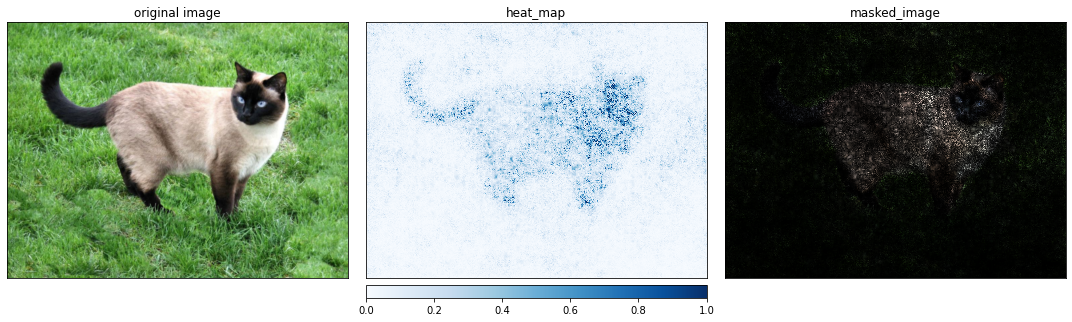

In [ ]:
saliency = Saliency(model)
attributions_saliency = saliency.attribute(input, target=pred_label_idx)
vis(attributions_saliency, transformed_img)

## Input X Gradient

Input X Gradient is an extension of the saliency approach, taking the gradients of the output with respect to the input and multiplying by the input feature values. One intuition for this approach considers a linear model; the gradients are simply the coefficients of each input, and the product of the input with a coefficient corresponds to the total contribution of the feature to the linear model's output.

/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


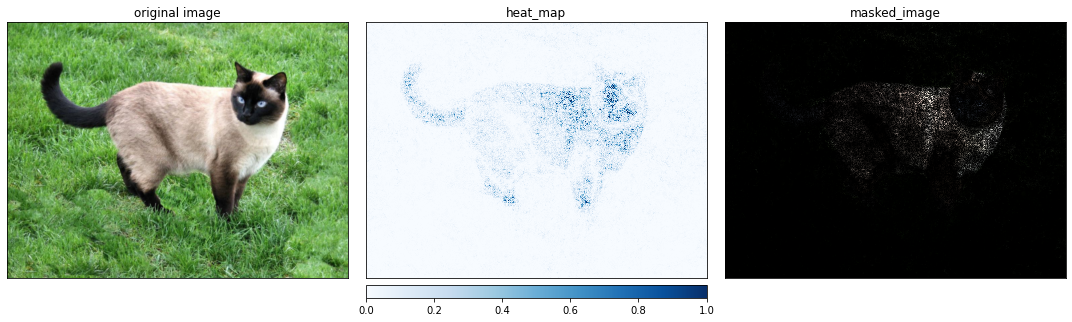

In [ ]:
inputXgradient = InputXGradient(model)
attributions_inputXgradient = inputXgradient.attribute(input, target=pred_label_idx)
vis(attributions_inputXgradient, transformed_img)

## Guided Backpropagation

Guided backpropagation and deconvolution compute the gradient of the target output with respect to the input, but backpropagation of ReLU functions is overridden so that only non-negative gradients are backpropagated. In guided backpropagation, the ReLU function is applied to the input gradients, and in deconvolution, the ReLU function is applied to the output gradients and directly backpropagated. Both approaches were proposed in the context of a convolutional network and are generally used for convolutional networks, although they can be applied generically.

/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


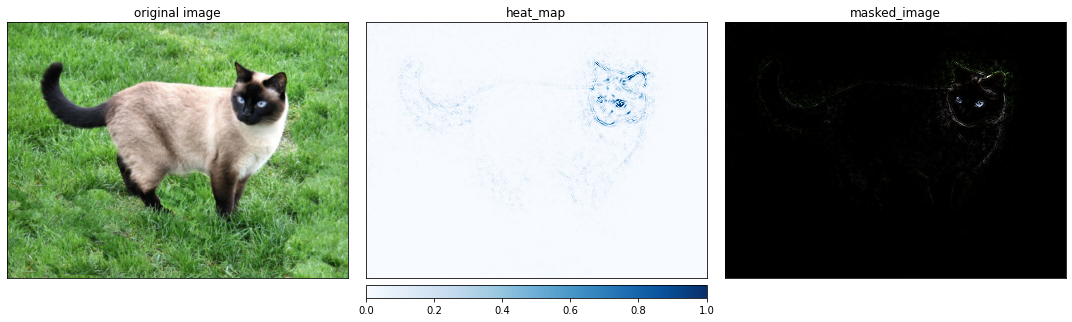

In [ ]:
guided_backprop = GuidedBackprop(model)
attributions_guided_backprop = guided_backprop.attribute(input, target=pred_label_idx)
vis(attributions_guided_backprop, transformed_img)

## Guided GradCAM 

Guided GradCAM computes the element-wise product of guided backpropagation attributions with upsampled (layer) GradCAM attributions. GradCAM attributions are computed with respect to a given layer, and attributions are upsampled to match the input size. This approach is designed for convolutional neural networks. The chosen layer is often the last convolutional layer in the network, but any layer that is spatially aligned with the input can be provided.

Guided GradCAM was proposed by the authors of GradCAM as a method to combine the high-resolution nature of Guided Backpropagation with the class-discriminative advantages of GradCAM, which has lower resolution due to upsampling from a convolutional layer.

![](http://gradcam.cloudcv.org/static/images/network.png)

/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


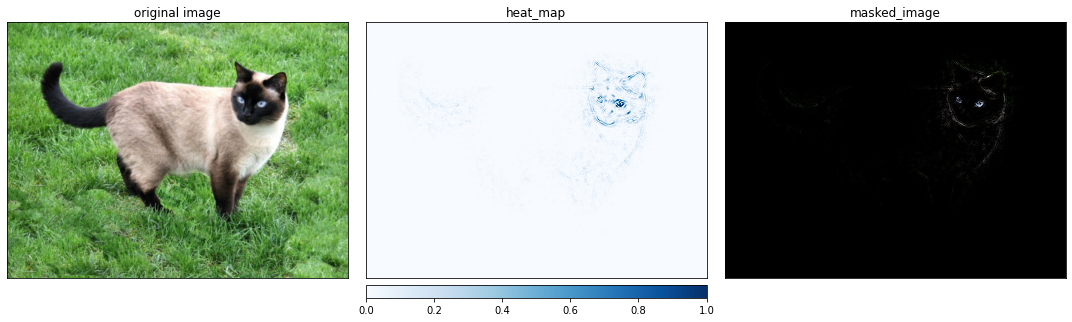

In [ ]:
guided_gradcam = GuidedGradCam(model, model.layer4)
attributions_guided_gradcam = guided_gradcam.attribute(input, target=pred_label_idx)
vis(attributions_guided_gradcam, transformed_img)

# Perturbation-Based methods

## Occlusion 

Occlusion is a perturbation based approach to compute attribution, involving replacing each contiguous rectangular region with a given baseline / reference, and computing the difference in output. For features located in multiple regions (hyperrectangles), the corresponding output differences are averaged to compute the attribution for that feature. Occlusion is most useful in cases such as images, where pixels in a contiguous rectangular region are likely to be highly correlated.

In the example below, we will try to estimate critical areas for the classifier decision by occluding them. 
Let's run a sliding window of size 60x60 (sliding_window_shapes parameter) with a stide of 40 along both image dimensions (strides parameter). 
Our baseline value will be 0 (baselines parameter). 

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 40, 40),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3, 60, 60),
                                       baselines=0)

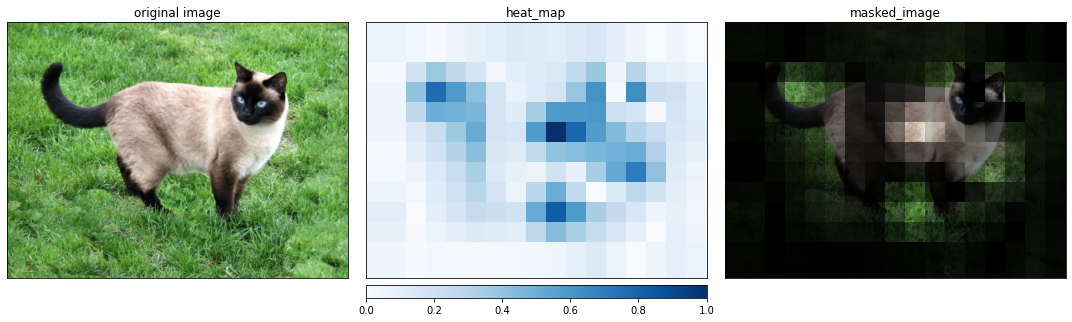

In [ ]:
vis(attributions_occ, transformed_img)
